# Advanced stuff 

Let's see how to do more advanced operations with Polars, like plotting, grouping with `group_by`, joining tables with `join`.

In [1]:
import polars as pl
import matplotlib.pyplot as plt

Let's first reload the dataframe from the previous course. As a warmup exercise, try to write code to get the following table _in a single assignment_ (meaning, only one `protests = ...`). There's just one new thing you should do compared to the previous course: start by filtering out rows for which the values in the column `"protest"` are different from 1.

In [3]:
protests

id,country,protester_violence,participants,start_date,end_date,duration
i64,str,bool,i64,date,date,duration[ms]
201990001,"""Canada""",false,1000,1990-01-15,1990-01-15,1d
201990002,"""Canada""",false,1000,1990-06-25,1990-06-25,1d
201990003,"""Canada""",false,500,1990-07-01,1990-07-01,1d
201990004,"""Canada""",true,100,1990-07-12,1990-09-06,57d
201990005,"""Canada""",true,950,1990-08-14,1990-08-15,2d
…,…,…,…,…,…,…
9102014001,"""Papua New Guinea""",true,100,2014-02-16,2014-02-18,3d
9102016001,"""Papua New Guinea""",true,1000,2016-05-15,2016-06-09,26d
9102017001,"""Papua New Guinea""",false,50,2017-06-15,2017-06-15,1d


## Plotting data 

While exploring data, looking at tables is often not the best to gain insights about your dataset. Fortunately, it's very easy to make quick plots based on a dataframe.

The first option is to use Matplotlib, and in particular, to make a quick plot you may use the *implicit* interface that we didn't cover in the Matplotlib chapter. Instead of first creating an `Axes` and then calling a plotting method, you might directly call an equivalent function from `plt` that will create the Figure and Axes for you:

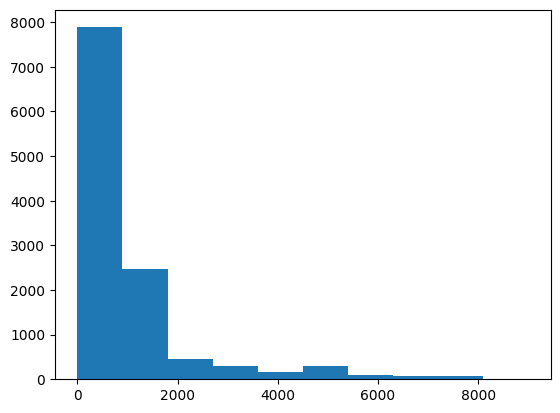

In [4]:
f = pl.col("participants") < 1e4
plt.hist('participants', data=protests.filter(f));

Note the use of the `data` argument in which we pass a dataframe, exactly as we did with a dictionary in [here](plt_inputs). Here we filtered protests with more than 10000 participants for visualization purposes.

If you have [hvplot](https://hvplot.holoviz.org/) installed, you can also make interactive plots from a dataframe, using the `.plot` accessor:

In [5]:
protests.filter(f).plot.scatter(x='start_date', y='participants', by='protester_violence')

:NdOverlay   [protester_violence]
   :Scatter   [start_date]   (participants)

### Exercise - time distribution

Plot the distribution of `start_date` in the dataset, first with `plt`, and then with `hvplot`, using 20 bins in both cases.

```{note}
Method and argument names are not always the same between `plt` and `hvplot`, but most of the time, they are!
```

## Aggregate

Here we'll cover the very basics of Dataframe aggregation. Head over to the [documentation](https://docs.pola.rs/user-guide/expressions/aggregation) for more.

### Globally

There is a number of statistics we can get from our dataset. For instance, we could compute the average duration of protests, as follows:

In [8]:
avg_duration = protests.select(pl.col("duration").mean().alias("average_duration"))
avg_duration

average_duration
duration[ms]
2d 14h 35m 1s 82ms


If you want to extract this single value into a usual Python type, you can use the `.item()` method:

In [9]:
avg_duration.item()

datetime.timedelta(days=2, seconds=52501, microseconds=82000)

```{note}
For an extensive list of operations that give aggregate results, see [the documentation](https://docs.pola.rs/api/python/stable/reference/expressions/aggregation.html).
```

### Let's group by something!

Now what if we want to get this statistic by country? That's what the `group_by` method is made for! To get an idea of what a group is, let us group by country, and look at the very first group as follows:

In [10]:
for (group, df) in protests.group_by('country'):
    print(group)
    display(df)
    break

('Sierra Leone',)


id,country,protester_violence,participants,start_date,end_date,duration
i64,str,bool,i64,date,date,duration[ms]
4511996001,"""Sierra Leone""",false,100,1996-09-07,1996-09-07,1d
4511996002,"""Sierra Leone""",false,100,1996-09-10,1996-09-10,1d
4511997001,"""Sierra Leone""",false,100,1997-01-15,1997-01-15,1d
4511997002,"""Sierra Leone""",false,100,1997-05-13,1997-05-13,1d
4511997003,"""Sierra Leone""",true,50,1997-08-18,1997-08-18,1d
…,…,…,…,…,…,…
4512017003,"""Sierra Leone""",false,50,2017-11-15,2017-11-15,1d
4512018001,"""Sierra Leone""",false,100,2018-04-04,2018-04-04,1d
4512018002,"""Sierra Leone""",false,500,2018-12-15,2018-12-15,1d


As you can see, when iterating over a `group_by` result, at each iteration we get a tuple. Its first element is the value of the `group_by` key (here, the country name), and its second the DataFrame corresponding to this value.

### Let's aggregate

Now let's say we want to get the average duration of protests that happened in each country. Naively, you could take the code above and compute the mean at each `for` iteration. Good news is, there is a simpler, faster way to do it, chaining the `.agg()` method:

In [11]:
protests.group_by("country").agg(pl.col("duration").mean().alias("average_duration")).head()

country,average_duration
str,duration[ms]
"""Japan""",1d 6h 30m 30s 508ms
"""Burkina Faso""",1d 5h 38m 49s 411ms
"""Nepal""",4d 1h 14m 21s 971ms
"""Ukraine""",4d 1h 46m 18s 523ms
"""Colombia""",4d 19h 9m 55s 683ms


And, exactly as with `.with_columns()` or `.select()`, you may perform as many aggregations as you want.

Try now to also add a new column to the dataframe above, featuring the number of protests by country, and sort the result so that countries with the most protests appear first (refer to the documentation linked above!):

In [13]:
country_stats

country,average_duration,number_of_protests
str,duration[ms],u32
"""United Kingdom""",1d 23h 55m 1s 38ms,578
"""France""",2d 7h 24m 53s 967ms,547
"""Ireland""",1d 1h 10m 9s 744ms,431
"""Germany""",1d 23h 36m 15s 824ms,364
"""Kenya""",1d 6h 55m 32s 571ms,350
…,…,…
"""Germany West""",1d,2
"""Serbia and Montenegro""",1d,2
"""Bhutan""",4d,2


![](img/df_agg.png)

### Exercise - Top protesters

Make a bar plot showing the number of protests in the 10 countries which had the most protests in their history.

```{tip}
You can use `Axes.barh` to make a horizontal bar plot.
```

```{tip}
When you have long categorical labels, such as country names here, it's often a good idea to use a horizontal bar plot.
```

### Modifying a dataframe by plugging in the result of a grouping

Sometimes, we may want to compute an aggregate statistic, to then use it to compute a metric in a new column. For instance, it is very common to want to compute a proportion or a ratio, which involves dividing a count by the sum of elements pertaining to each group. Let's then compute for each protest the ratio of participants that it represented.

If we proceed as above, we'd start by performing the following `group_by` aggregation:

In [15]:
protests.group_by("country").agg(pl.col("participants").sum().alias("participants_sum")).head()

country,participants_sum
str,i64
"""Kazakhstan""",116725
"""Croatia""",290310
"""Kuwait""",32000
"""Japan""",783195
"""Saudi Arabia""",15830


In fact, in that case we don't need to call `group_by()`, but rather:

In [16]:
protests = protests.with_columns(
    pl.col("participants").sum().over("country").alias("participants_sum")
).with_columns(participant_ratio=pl.col("participants") / pl.col("participants_sum"))
protests.head()

id,country,protester_violence,participants,start_date,end_date,duration,participants_sum,participant_ratio
i64,str,bool,i64,date,date,duration[ms],i64,f64
201990001,"""Canada""",false,1000,1990-01-15,1990-01-15,1d,617570,0.001619
201990002,"""Canada""",false,1000,1990-06-25,1990-06-25,1d,617570,0.001619
201990003,"""Canada""",false,500,1990-07-01,1990-07-01,1d,617570,0.00081
201990004,"""Canada""",true,100,1990-07-12,1990-09-06,57d,617570,0.000162
201990005,"""Canada""",true,950,1990-08-14,1990-08-15,2d,617570,0.001538


In the end, all you want to do is add a column, so you start as always by calling `.with_columns()` and selecting the column from which you'll use the data with `pl.col("participants")`. The new element here is that, then, you perform the `.sum().over()` operation, that will perform the transformation (the sum) over the window defined by the argument of `over()` (here, the "country" column values).

## Joining tables

### Getting another table

Suppose we want to add a column with the population of each country, to compute the proportion of the population that participated in protests, for instance. To do so, we would need to join our dataset with another one containing such information. Let's take for example the dataset [countries_pop.csv](data/countries_pop.csv), from the [World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL):

In [17]:
countries_pop = pl.read_csv('data/countries_pop.csv')

ComputeError: found more fields than defined in 'Schema'

Consider setting 'truncate_ragged_lines=True'.

Ah, looks like we're off to a great start! And that error message is not the clearest. So let's have a quick look at our data file:

In [18]:
!head data/countries_pop.csv

"Data Source","World Development Indicators",

"Last Updated Date","2024-05-30",

"Country Name","Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966","1967","1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021","2022","2023",
"Aruba","ABW","Population, total","SP.POP.TOTL","54608","55811","56682","57475","58178","58782","59291","59522","59471","59330","59106","58816","58855","59365","60028","60715","61193","61465","61738","62006","62267","62614","63116","63683","64174","64478","64553","64450","64332","64596","65712","67864","70192","72360","74710","77050","79417","81858","84355","86867","89101","90691","91781","92701","9354

```{note}
Here, we use the cell magic `!` to run a system command called `head`, which, exactly as for dataframes (or is it the other way around?), shows you the first lines of a file. You're not expected to learn this kind of commands in this course, this was simply to show that you can do that in Jupyter, and that it's very practical.
```

```{admonition} Question
Having seen that, can you guess what the problem was? How is this file different from the ones we've seen previously?
```

```{admonition} Answer
:class: tip dropdown
The 4 first lines actually contain some metadata about the file, and the header specifying column names is only on the 5th line! That's why Polars complains about the Schema, it thought that the first line was defining the columns, but then found more columns in following lines. Fortunately, Polars lets us skip rows from CSV files, using the `skip_rows` argument.
```

In [19]:
countries_pop = pl.read_csv('data/countries_pop.csv', skip_rows=4)
countries_pop.head()

Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,
str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str
"""Aruba""","""ABW""","""Population, total""","""SP.POP.TOTL""",54608,55811,56682,57475,58178,58782,59291,59522,59471,59330,59106,58816,58855,59365,60028,60715,61193,61465,61738,62006,62267,62614,63116,63683,64174,64478,64553,64450,64332,64596,65712,67864,70192,72360,74710,77050,79417,81858,84355,86867,89101,90691,91781,92701,93540,94483,95606,96787,97996,99212,100341,101288,102112,102880,103594,104257,104874,105439,105962,106442,106585,106537,106445,"""""",null
"""Africa Eastern and Southern""","""AFE""","""Population, total""","""SP.POP.TOTL""",130692579,134169237,137835590,141630546,145605995,149742351,153955516,158313235,162875171,167596160,172475766,177503186,182599092,187901657,193512956,199284304,205202669,211120911,217481420,224315978,230967858,237937461,245386717,252779730,260209149,267938123,276035920,284490394,292795186,301124880,309890664,318544083,326933522,335625136,344418362,353466601,362985802,372352230,381715600,391486231,401600588,412001885,422741118,433807484,445281555,457153837,469508516,482406426,495748900,509410477,523459657,537792950,552530654,567892149,583651101,600008424,616377605,632746570,649757148,667242986,685112979,702977106,720859132,"""""",null
"""Afghanistan""","""AFG""","""Population, total""","""SP.POP.TOTL""",8622466,8790140,8969047,9157465,9355514,9565147,9783147,10010030,10247780,10494489,10752971,11015857,11286753,11575305,11869879,12157386,12425267,12687301,12938862,12986369,12486631,11155195,10088289,9951449,10243686,10512221,10448442,10322758,10383460,10673168,10694796,10745167,12057433,14003760,15455555,16418912,17106595,17788819,18493132,19262847,19542982,19688632,21000256,22645130,23553551,24411191,25442944,25903301,26427199,27385307,28189672,29249157,30466479,31541209,32716210,33753499,34636207,35643418,36686784,37769499,38972230,40099462,41128771,"""""",null
"""Africa Western and Central""","""AFW""","""Population, total""","""SP.POP.TOTL""",97256290,99314028,101445032,103667517,105959979,108336203,110798486,113319950,115921723,118615741,121424797,124336039,127364044,130563107,133953892,137548613,141258400,145122851,149206663,153459665,157825609,162323313,167023385,171566640,176054495,180817312,185720244,190759952,195969722,201392200,206739024,212172888,217966101,223788766,229675775,235861484,242200260,248713095,255482918,262397030,269611898,277160097,284952322,292977949,301265247,309824829,318601484,327612838,336893835,346475221,356337762,366489204,376797999,387204553,397855507,408690375,419778384,431138704,442646825,454306063,466189102,478185907,490330870,"""""",null
"""Angola""","""AGO""","""Population, total""","""SP.POP.TOTL""",5357195,5441333,5521400,5599827,5673199,5736582,5787044,5827503,5868203,5928386,6029700,6177049,6364731,6578230,6802494,7032713,7266780,7511895,7771590,8043218,8330047,8631457,8947152,9276707,9617702,9970621,10332574,10694057,11060261,11439498,11828638,12228691,12632507,13038270,13462031,13912253,14383350,14871146,15366864,15870753,16394062,16941587,17516139,18124342,18771125,19450959,20162340,20909684,21691522,22507674,23364185,24259111,25188292,26147002,27128337,28127721,29154746,30208628,31273533,32353588,33428486,34503774,35588987,"""""",null


As you can see, there is one row per country, and the population counts are given in separate columns, for years ranging between 1960 and 2022. So in principle, when adding in the population data to `protests`, we should add the population corresponding to the protest's year. For the sake of simplicity though, here we'll take populations from a single year. But let's at least choose it reasonably. We've already seen graphically the distribution of `start_date`, but let's get some summary statistics.

As a small exercise, try to get the following table (hint: use the `Dataframe.describe()` method):

We see that the average sits toward the end of 2006, while the median towards the end of 2007. Let us then take 2007 as our year to get populations. Go ahead and assign a new variable `countries_single_pop` with the dataframe containing the populations of that year:

### Performing the `join`

Now, adding in these populations to `protests` is as simple as:

In [22]:
protests_with_pop = protests.join(countries_single_pop, on="country")
protests_with_pop.head()

id,country,protester_violence,participants,start_date,end_date,duration,participants_sum,participant_ratio,pop_2007
i64,str,bool,i64,date,date,duration[ms],i64,f64,i64
201990001,"""Canada""",false,1000,1990-01-15,1990-01-15,1d,617570,0.001619,32889025
201990002,"""Canada""",false,1000,1990-06-25,1990-06-25,1d,617570,0.001619,32889025
201990003,"""Canada""",false,500,1990-07-01,1990-07-01,1d,617570,0.00081,32889025
201990004,"""Canada""",true,100,1990-07-12,1990-09-06,57d,617570,0.000162,32889025
201990005,"""Canada""",true,950,1990-08-14,1990-08-15,2d,617570,0.001538,32889025


The `on` argument allows you to set the column the `join` will consider to match. Here, the column `"country"` exists in both Dataframes, so we can simply set it to that. However, if, for instance, `countries_single_pop` still had the `"Country Name"` column, instead of `on="country"`, we'd have had to specify `left_on="country", right_on="Country Name"`.

`join` has another very important argument: `how`. To get an idea of what it does, let us compare the shape of `protests_with_pop` with the original `protests`:

In [23]:
protests_with_pop.shape, protests.shape

((12743, 10), (15239, 9))

As you can see, we lost some rows! Why? Because by default, the argument `how` is set to `"inner"`. This means that the dataframe output by `join` will only have rows for which the `"country"` exists in both input dataframes. To conserve the rows of the original dataframe, you can set `how="left"` instead:

In [24]:
full_protests_with_pop = protests.join(countries_single_pop, on="country", how="left")
full_protests_with_pop.shape

(15239, 10)

And we did conserve our number of rows.

```{admonition} Question
But then, what happened to rows in which we could not find a matching country in `countries_single_pop`? 
```

![](img/df_join.png)

### Exercise - proportion of protesters

Compute the proportion of the total population that protested in each protest, and show the countries in which the maximum proportion is highest.

In [26]:
top_protesters.head()

country,max_prop_of_pop
str,f64
"""Lebanon""",0.207917
"""Moldova""",0.139164
"""Armenia""",0.133138
"""Guinea""",0.104744
"""Greece""",0.09051


Now slightly harder, try to get the full row corresponding to that protest in which the maximum `"prop_of_pop"` was reached.

```{hint}
You'll find the [`Expression.sort_by()`](https://docs.pola.rs/api/python/stable/reference/expressions/api/polars.Expr.sort_by.html) method useful for that.
```

In [28]:
top_protesters.head()

country,id,protester_violence,participants,start_date,end_date,duration,participants_sum,participant_ratio,pop_2007,prop_of_pop
str,i64,bool,i64,date,date,duration[ms],i64,f64,i64,f64
"""Lebanon""",6602006001,false,1000000,2006-02-15,2006-02-15,1d,4800000,0.208333,4809608,0.207917
"""Moldova""",3591991003,false,400000,1991-08-21,1991-08-21,1d,1112256,0.359629,2874299,0.139164
"""Armenia""",3711992001,false,400000,1992-11-02,1992-11-02,1d,1616170,0.247499,3004393,0.133138
"""Guinea""",4382019010,false,1000000,2019-12-10,2019-12-10,1d,2647050,0.377779,9547082,0.104744
"""Greece""",3502012001,true,1000000,2012-02-07,2012-02-07,1d,3302570,0.302794,11048473,0.09051


### Exercise - doing things right

Beforehand, we just took the population of a single year, while each protest happened on different years. In reality, we can know this year from the `"start_date"` column. Reproduce the above to get `protests_with_pop`, taking into account the right population.

```{tip}
- To start off, you'll need to call the Dataframe method [`.unpivot()`](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.unpivot.html) on `countries_pop`.
- To select all year columns, don't write them by hand! There are (at least) two ways to select all of them lazily.
```

In [30]:
protests_with_pop.head()

id,country,protester_violence,participants,start_date,end_date,duration,participants_sum,participant_ratio,year,pop
i64,str,bool,i64,date,date,duration[ms],i64,f64,i32,i64
3391990001,"""Albania""",false,null,1990-07-06,1990-07-06,1d,381150,null,1990,3286542
3391990002,"""Albania""",true,null,1990-12-09,1990-12-09,1d,381150,null,1990,3286542
3391990003,"""Albania""",false,9000,1990-12-12,1990-12-12,1d,381150,0.023613,1990,3286542
3391990004,"""Albania""",true,50,1990-12-13,1990-12-13,1d,381150,0.000131,1990,3286542
3391990005,"""Albania""",true,null,1990-12-15,1990-12-16,2d,381150,null,1990,3286542


Now, check that it worked by checking out Italy, for instance.

In [32]:
yearly_pop_italy

year,pop
i32,i64
1990,56719240
1991,56758521
1992,56797087
1993,56831821
1994,56843400
…,…
2014,60789140
2016,60627498
2017,60536709


## Be lazy

A great strength of Polars is its lazy mode. In this mode, instead of working with *Dataframes*, you work with *Lazyframes*. The big difference between the two is that, while the Dataframes actually hold *data*, Lazyframes just hold *a set of operations* to execute.

The first way to obtain a Lazyframe is to call the `.lazy()` method on an existing Dataframe, like so:

In [33]:
type(protests.lazy())

polars.lazyframe.frame.LazyFrame

But actually, to get the most out of the lazy mode, you should rather work with Lazyframes *before you even read any data*. In practice, this means that, instead of calling `pl.read_<file-format>()` to read from a data source, you'll call an equivalent `pl.scan_<file-format>()`. For instance:

In [34]:
lazy_protests = pl.scan_csv('data/protests.csv')
lazy_protests

As you can see, no data is shown, simply because no data was read! With this object, you can now call all methods seen until now, as if you were dealing with a regular Dataframe. In order to actually get the result of a computation, you simply need to call the `.collect()` method at the very end.

Let us show by example the power of using Lazyframes. Let's compute the median number of participants by year in Italy, in a particularly stupid way:

In [35]:
%%time
dumb_agg = (
    pl.read_csv("data/protests.csv")
    .with_columns(
        pl.col("participants").str.extract("([0-9]+)").cast(int),
    )
    .group_by("country", "year")
    .agg(pl.col("participants").median())
    .filter(pl.col("country") == "Italy")
)
dumb_agg.head()

CPU times: user 137 ms, sys: 22.1 ms, total: 159 ms
Wall time: 26.1 ms


country,year,participants
str,i64,f64
"""Italy""",2005,1200.0
"""Italy""",1999,50.0
"""Italy""",2008,1000.0
"""Italy""",2004,100.0
"""Italy""",1995,50.0


```{admonition} Question
Why is this not very smart? How could we make this operation more efficient?
```

```{admonition} Answer
:class: tip dropdown
Because we're computing this median for every single country, while we're only interested in Italy here! The `filter()` should be called directly after reading the CSV.
```

Let's time the same thing, except that we do everything in lazy mode:

In [36]:
%%time
lazy_agg = (
    pl.scan_csv("data/protests.csv")
    .with_columns(
        pl.col("participants").str.extract("([0-9]+)").cast(int),
    )
    .group_by("country", "year")
    .agg(pl.col("participants").median())
    .filter(pl.col("country") == "Italy")
)
lazy_agg.collect().head()

CPU times: user 16.9 ms, sys: 12.1 ms, total: 29 ms
Wall time: 5.01 ms


country,year,participants
str,i64,f64
"""Italy""",2017,50.0
"""Italy""",2002,1000.0
"""Italy""",2008,1000.0
"""Italy""",2005,1200.0
"""Italy""",1994,500025.0


That's a big difference in timing, and for relatively simple operations performed on a relatively small dataset!

But why is there this difference? It's because, before calling `.collect()`, Polars will run what is called a *query optimization*, and automatically reorder and modify the operations performed in the `collect`, to make them as optimal as it can. To see that, you can call `.show_graph()` to find out what the optimization did:

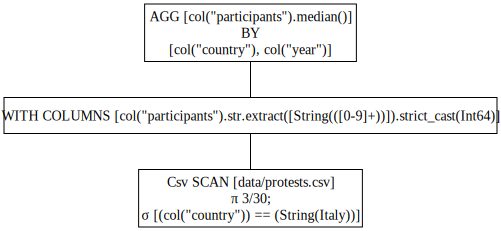

In [37]:
lazy_agg.show_graph()

This is to be read from the bottom up. As you can see, the filter has been *pushed down* to the very moment data is read! Which does make a lot of sense, doesn't it?

To sum up, there are two main advantages of using Lazyframes:
- You get an automatic query optimization. So even if the code you wrote could be much more optimal, it will run as fast as it can. In other words, being lazy enables you to be dumb, and not suffer the consequences.
- As filters can be pushed down to the very moment data is read, you don't need to load all data in memory! This means that you could still analyse data files which are too big to fit in your computer memory!

### Exercise -  Healthcare facilities 

✪✪ Let's examine the dataset [SANSTRUT001.csv](data/SANSTRUT001.csv) which contains the healthcare facilities of Trentino region, and for each tells the type of assistance it offers (clinical activity, diagnostics, etc), the code and name of the communality where it is located.


Data source: [dati.trentino.it](https://dati.trentino.it/dataset/strutture-sanitarie-dell-azienda-sanitaria-e-convenzionate) Licenza: [Creative Commons Attribution 4.0](http://creativecommons.org/licenses/by/4.0/deed.it)

Write a function which takes as input a town code and a text string, opens the file **lazily** and:

1. PRINTS also the number of found rows
2. RETURNS a dataframe with selected only the rows having that town code and which contain the string in the column `ASSISTENZA`. The returned dataset must have only the columns 
`STRUTTURA`, `ASSISTENZA`, `COD_COMUNE`, `COMUNE`. 

In [38]:
def strutsan(cod_comune, assistenza):
    struprotests = pl.scan_csv("data/SANSTRUT001.csv")
    res = struprotests.filter(
        (pl.col("COD_COMUNE") == cod_comune)
        & pl.col("ASSISTENZA").str.contains(assistenza)
    ).collect()

    print("Found", res.shape[0], "facilities")
    return res.select("STRUTTURA", "ASSISTENZA", "COD_COMUNE", "COMUNE")

In [39]:
strutsan(22050, '')  # no ASSISTENZA filter

Found 6 facilities


STRUTTURA,ASSISTENZA,COD_COMUNE,COMUNE
str,str,i64,str
"""PRESIDIO OSPEDALIERO DI CAVALE…","""ATTIVITA` CLINICA""",22050,"""CAVALESE"""
"""PRESIDIO OSPEDALIERO DI CAVALE…","""DIAGNOSTICA STRUMENTALE E PER …",22050,"""CAVALESE"""
"""PRESIDIO OSPEDALIERO DI CAVALE…","""ATTIVITA` DI LABORATORIO""",22050,"""CAVALESE"""
"""CENTRO SALUTE MENTALE CAVALESE""","""ASSISTENZA PSICHIATRICA""",22050,"""CAVALESE"""
"""CENTRO DIALISI CAVALESE""","""ATTIVITA` CLINICA""",22050,"""CAVALESE"""
"""CONSULTORIO CAVALESE""","""ATTIVITA` DI CONSULTORIO MATER…",22050,"""CAVALESE"""


In [40]:
strutsan(22205, 'CLINICA')

Found 16 facilities


STRUTTURA,ASSISTENZA,COD_COMUNE,COMUNE
str,str,i64,str
"""PRESIDIO OSPEDALIERO S.CHIARA""","""ATTIVITA` CLINICA""",22205,"""TRENTO"""
"""CENTRO DIALISI TRENTO""","""ATTIVITA` CLINICA""",22205,"""TRENTO"""
"""POLIAMBULATORI S.CHIARA""","""ATTIVITA` CLINICA""",22205,"""TRENTO"""
"""PRESIDIO OSPEDALIERO VILLA IGE…","""ATTIVITA` CLINICA""",22205,"""TRENTO"""
"""OSPEDALE CLASSIFICATO S.CAMIL…","""ATTIVITA` CLINICA""",22205,"""TRENTO"""
…,…,…,…
"""COOPERATIVA SOCIALE IRIFOR DEL…","""ATTIVITA` CLINICA""",22205,"""TRENTO"""
"""AGSAT ASSOCIAZIONE GENITORI SO…","""ATTIVITA` CLINICA""",22205,"""TRENTO"""
"""AZIENDA PUBBLICA SERVIZI ALLA …","""ATTIVITA` CLINICA""",22205,"""TRENTO"""


In [41]:
strutsan(22205, 'LABORATORIO')

Found 5 facilities


STRUTTURA,ASSISTENZA,COD_COMUNE,COMUNE
str,str,i64,str
"""PRESIDIO OSPEDALIERO S.CHIARA""","""ATTIVITA` DI LABORATORIO""",22205,"""TRENTO"""
"""LABORATORI ADIGE SRL""","""ATTIVITA` DI LABORATORIO""",22205,"""TRENTO"""
"""LABORATORIO DRUSO SRL""","""ATTIVITA` DI LABORATORIO""",22205,"""TRENTO"""
"""CASA DI CURA VILLA BIANCA SPA""","""ATTIVITA` DI LABORATORIO""",22205,"""TRENTO"""
"""CENTRO SERVIZI SANITARI""","""ATTIVITA` DI LABORATORIO""",22205,"""TRENTO"""


## Some more exercises

### Exercise - Air pollutants

Let's try to analyse the hourly data from air quality monitoring stations from Autonomous Province of Trento.

Source: [dati.trentino.it](https://dati.trentino.it/dataset/qualita-dell-aria-rilevazioni-delle-stazioni-monitoraggio)

#### Load the file

✪ Load the file [aria.csv](data/aria.csv) in Polars 

**IMPORTANT 1**: put the dataframe into the variable `aria`, so not to confuse it with the previous datasets.

**IMPORTANT 2**: use encoding `'latin-1'` 
(otherwise you might get weird load errors according to your operating system)

```{tip}
If you get an error, read it carefully, what is the issue here? What column is causing it? Then, use `pl.read_csv?` or head over to [the documentation](https://docs.pola.rs/api/python/stable/reference/api/polars.read_csv.html) and read the Notes, that will get you closer to the solution.
```

#### Pollutants average

✪ find the average of `PM10` pollutants  at `Parco S. Chiara` (average on all days).

#### PM10 chart

✪ Use `Axes.plot` to show in a chart the values of `PM10` in Parco S. Chiara on May 7th, 2019.

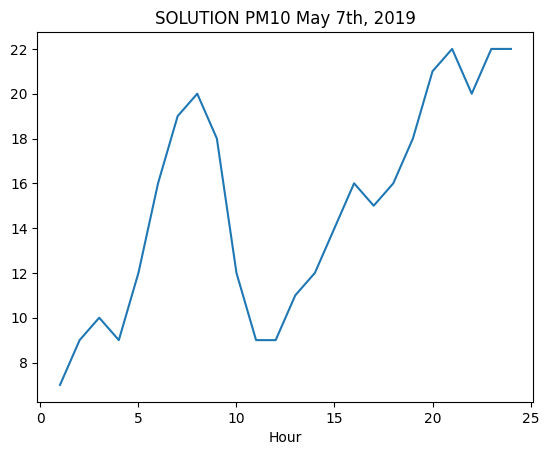

In [45]:
fig

### Exercise - meteo pressure intervals

✪✪✪ The dataset [meteo.csv](data/meteo.csv) contains the weather data of Trento, November 2017 (source: [www.meteotrentino.it](https://www.meteotrentino.it)). We would like to subdivide the pressure readings into three intervals `A (low)`, `B (medium)`, `C (high)`, and count how many readings have been made for each interval.  

**IMPORTANT**: assign the dataframe to a variable called `meteo` so to avoid confusion with other dataframes

#### Where are the intervals?

First, let's find the pressure values for these 3 intervals and plot them as segments, so to end up with a chart like this:

Before doing the plot, we will need to know at which height we should plot the segments.

Load the dataset with polars, calculate the following variables and PRINT them 

- round values with `round` function
- the excursion is the difference between minimum and maximum
- note `intervalC` coincides with the maximum

**DO NOT** use `min` and `max` as variable names (they are reserved functions!!)

#### Segments plot 

Try now to plot the chart of pressure and the 4 horizontal segments.

- to overlay the segments with different colors, just make repeated calls to `ax.plot`
- a segment is defined by two points: so just find the coordinates of those two points..

**REMEMBER** title and labels

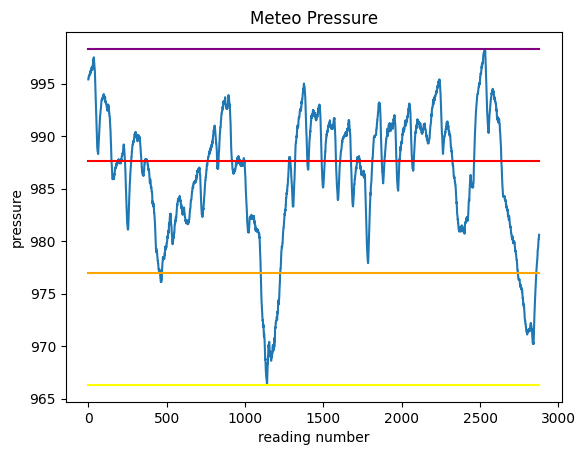

In [48]:
fig

#### Assigning the intervals

We literally made a picture of where the intervals are located - let's now ask ourselves how many readings have been done for each interval.

First, try creating a column which assigns to each reading the interval where it belongs to.

```{tip}
You will need the function `pl.when()`, start by inspecting it!
```

In [50]:
meteo.head()

Date,Pressure,Rain,Temp,PressureInterval
str,f64,f64,f64,str
"""01/11/2017 00:00""",995.4,0.0,5.4,"""C (high)"""
"""01/11/2017 00:15""",995.5,0.0,6.0,"""C (high)"""
"""01/11/2017 00:30""",995.5,0.0,5.9,"""C (high)"""
"""01/11/2017 00:45""",995.7,0.0,5.4,"""C (high)"""
"""01/11/2017 01:00""",995.7,0.0,5.3,"""C (high)"""


#### Grouping by intervals

a. First, create a grouping to count occurrences:

In [52]:
press_groups

PressureInterval,Pressure
str,u32
"""B medium""",1243
"""C (high)""",1380
"""A (low)""",255


b. Now plot it

- **REMEMBER** title and axis labels

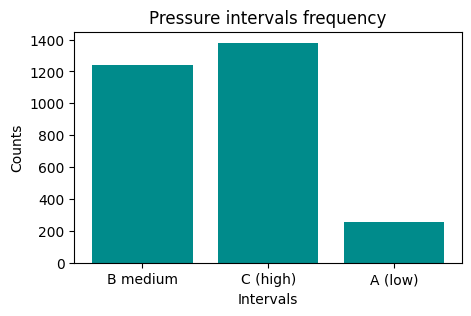

In [54]:
fig

### Exercise - meteo average temperature

✪✪✪ Calculate the average temperature for each day, and show it in the plot.

**HINT**: add  `'Day'` column by extracting only the day from the date. To do it, use the function `.str.slice`.

In [56]:
meteo.head()

Date,Pressure,Rain,Temp,Day,avg_day_temp
str,f64,f64,f64,str,f64
"""01/11/2017 00:00""",995.4,0.0,5.4,"""01/11/2017""",7.983333
"""01/11/2017 00:15""",995.5,0.0,6.0,"""01/11/2017""",7.983333
"""01/11/2017 00:30""",995.5,0.0,5.9,"""01/11/2017""",7.983333
"""01/11/2017 00:45""",995.7,0.0,5.4,"""01/11/2017""",7.983333
"""01/11/2017 01:00""",995.7,0.0,5.3,"""01/11/2017""",7.983333


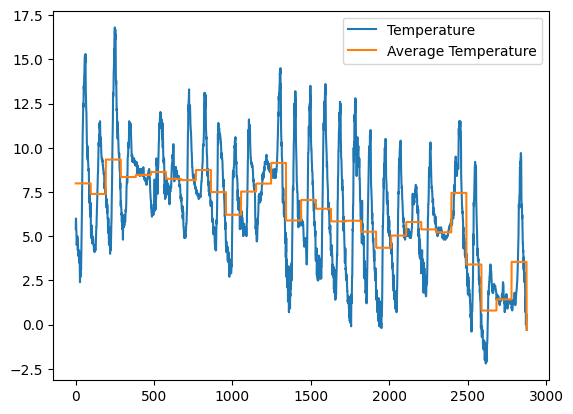

In [58]:
fig